
# Embeddings Comparison: Word2Vec, FastText, GloVe, spaCy, SBERT, Raw BERT
Run cells top-to-bottom. Edit the **Data** section to plug in your own corpus.


## 1) Setup & Imports

In [2]:
!pip install gensim nltk sentence-transformers spacy scikit-learn matplotlib umap-learn transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.0/488.0 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.9 MB/s eta 0:00:00


In [3]:

import re
import numpy as np
from pprint import pprint

# Visualization & eval
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import umap

# Tokenization
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Gensim
import gensim.downloader as api
from gensim.models import Word2Vec, FastText

# Sentence Transformers (SBERT)
from sentence_transformers import SentenceTransformer

# spaCy (quick sentence/word vecs)
import spacy

# Transformers (raw BERT)
from transformers import AutoTokenizer, AutoModel
import torch

print("✅ Imports loaded")


/usr/local/lib/python3.12/dist-packages/torch_xla/experimental/gru.py:113: SyntaxWarning: invalid escape sequence '\_'
  * **h_n**: tensor of shape :math:`(D * \text{num\_layers}, H_{out})` or
/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


✅ Imports loaded


## 2) Data

In [4]:

RAW_TEXT = """
King and queen rule a kingdom. A man and a woman walk to Rome in Italy.
Paris is the capital of France. Apple and banana are fruits.
The queen and the woman visited Paris. The king and the man visited Rome.
A royal family governs the kingdom, and their palace is in the capital.
Italy and France are European countries. Rome and Paris are famous cities.
Apples and bananas are often found in markets across the cities.
"""

SENTENCES = [
    "Paris is the capital of France.",
    "Rome is the capital of Italy.",
    "Apples and bananas are common fruits.",
    "The king and the queen live in a palace.",
    "A woman walked to Rome.",
    "Bananas are sold in city markets.",
    "France and Italy are European countries.",
    "The royal family rules the kingdom.",
]

CONTENT_WORDS = [
    "king","queen","man","woman",
    "paris","france","rome","italy",
    "kingdom","palace","capital","country","city",
    "apple","banana","fruit","family","royal"
]

print("✅ Data loaded (edit RAW_TEXT/SENTENCES for your corpus)")


✅ Data loaded (edit RAW_TEXT/SENTENCES for your corpus)


## 3) Sentence Split + Tokenization (stopwords removed)

In [6]:

nltk.download("punkt_tab", quiet=True)
nltk.download("stopwords", quiet=True)
stops = set(stopwords.words("english"))

def sentence_split(text: str):
    # Simple, dependency-light split
    return [s.strip() for s in re.split(r"[.\n!?]+", text) if s.strip()]

def tokenize_line(line: str):
    toks = [t.lower() for t in word_tokenize(line) if t.isalpha()]
    toks = [t for t in toks if t not in stops]  # remove stopwords
    return toks

sentences_raw = sentence_split(RAW_TEXT)
tokenized = [tokenize_line(s) for s in sentences_raw]

print("=== Tokenized sentences (first 8) ===")
for i, s in enumerate(tokenized[:8], 1):
    print(f"{i:02d}:", s)


=== Tokenized sentences (first 8) ===
01: ['king', 'queen', 'rule', 'kingdom']
02: ['man', 'woman', 'walk', 'rome', 'italy']
03: ['paris', 'capital', 'france']
04: ['apple', 'banana', 'fruits']
05: ['queen', 'woman', 'visited', 'paris']
06: ['king', 'man', 'visited', 'rome']
07: ['royal', 'family', 'governs', 'kingdom', 'palace', 'capital']
08: ['italy', 'france', 'european', 'countries']


## 4) Train Word2Vec & FastText (gensim)

In [7]:

w2v = Word2Vec(
    sentences=tokenized,
    vector_size=100,
    window=5,
    min_count=1,       # keep low for demo; raise to >=5 on real corpora
    workers=4,
    sg=1,              # skip-gram
    negative=10,
    sample=1e-3,
    epochs=200,
    seed=7
)

ft = FastText(
    sentences=tokenized,
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    sg=1,
    negative=10,
    sample=1e-3,
    epochs=200,
    seed=7
)

w2v_kv = w2v.wv
ft_kv  = ft.wv

print("✅ Trained Word2Vec & FastText")


✅ Trained Word2Vec & FastText


## 5) Load Pretrained: GloVe, spaCy, SBERT, Raw BERT

In [10]:

print("Loading pretrained models (GloVe, spaCy, SBERT, BERT)...")
!python -m spacy download en_core_web_md

# GloVe word vectors
glove = api.load("glove-wiki-gigaword-100")

# spaCy medium model; exclude lemmatizer to avoid W108 warning
nlp = spacy.load("en_core_web_md")

# SBERT sentence embeddings
sbert = SentenceTransformer("all-MiniLM-L6-v2")

# Raw BERT for mean-pooled sentence embeddings
bert_tok = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModel.from_pretrained("bert-base-uncased")
bert_model.eval()

print("✅ Pretrained models ready")


Loading pretrained models (GloVe, spaCy, SBERT, BERT)...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 48.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

✅ Pretrained models ready


## 6) Utilities

In [11]:

def cos(a, b):
    a = np.asarray(a); b = np.asarray(b)
    return float(np.dot(a, b) / ((np.linalg.norm(a) + 1e-9)*(np.linalg.norm(b) + 1e-9)))

def vec_gensim_word(model, word):
    return model[word] if word in model.key_to_index else None

def vec_glove_word(word):
    return glove[word] if word in glove.key_to_index else None

def embed_spacy(texts):
    # doc.vector: averaged pretrained word vectors
    docs = list(nlp.pipe(texts, disable=["tagger","parser","ner"]))
    X = np.vstack([d.vector for d in docs])
    X = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-9)
    return X

def sbert_embed(texts):
    return sbert.encode(texts, normalize_embeddings=True)

@torch.no_grad()
def bert_sentence_embed(texts):
    enc = bert_tok(texts, padding=True, truncation=True, return_tensors="pt")
    out = bert_model(**enc).last_hidden_state  # (B, T, H)
    mask = enc["attention_mask"].unsqueeze(-1)
    summed = (out * mask).sum(dim=1)
    counts = mask.sum(dim=1).clamp(min=1)
    mean = (summed / counts).cpu().numpy()
    mean = mean / (np.linalg.norm(mean, axis=1, keepdims=True) + 1e-9)
    return mean

print("✅ Utilities ready")


✅ Utilities ready


## 7) Sample Embeddings (Word2Vec / FastText / GloVe)

In [12]:

def show_vector(label, vec, head=8):
    if vec is None:
        print(f"(missing) '{label}' has no vector")
        return
    print(f"\nVector for '{label}' (first {head} dims of {len(vec)}):")
    print(np.array2string(vec[:head], precision=4, suppress_small=True))

for w in ["king","queen","paris","france","rome","italy","apple","banana","palace","capital"]:
    show_vector(f"W2V:{w}", vec_gensim_word(w2v_kv, w))
    show_vector(f"FT :{w}", vec_gensim_word(ft_kv, w))
    show_vector(f"GloVe:{w}", vec_glove_word(w))



Vector for 'W2V:king' (first 8 dims of 100):
[ 0.0035  0.0082 -0.0065  0.0062 -0.005  -0.0076  0.0016 -0.0106]

Vector for 'FT :king' (first 8 dims of 100):
[-0.0004 -0.003   0.0035 -0.0063 -0.007  -0.0009 -0.0009  0.0025]

Vector for 'GloVe:king' (first 8 dims of 100):
[-0.3231 -0.8762  0.2198  0.2527  0.2298  0.7388 -0.3795 -0.3531]

Vector for 'W2V:queen' (first 8 dims of 100):
[ 0.0153  0.0065 -0.0053  0.0097 -0.0053  0.0064 -0.0113 -0.0032]

Vector for 'FT :queen' (first 8 dims of 100):
[ 0.0036 -0.0037  0.0027 -0.0048 -0.0049  0.0012 -0.0005 -0.0006]

Vector for 'GloVe:queen' (first 8 dims of 100):
[-0.5005 -0.7083  0.5539  0.673   0.2249  0.6028 -0.2619  0.7387]

Vector for 'W2V:paris' (first 8 dims of 100):
[ 0.0156  0.0129  0.0025  0.0116 -0.0041  0.0054  0.0013 -0.0092]

Vector for 'FT :paris' (first 8 dims of 100):
[ 0.0013 -0.0038  0.0023 -0.0024 -0.0027 -0.0016 -0.0025  0.0012]

Vector for 'GloVe:paris' (first 8 dims of 100):
[ 0.9261 -0.2282 -0.2552  0.74    0.5007  0.26

## 7b) Sentence-level vectors + cosine similarities + heatmaps (spaCy / SBERT / BERT)

/usr/local/lib/python3.12/dist-packages/spacy/pipeline/lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)



=== spaCy sentence vectors ===

The king and the queen live in a palace.
first 8 of 300 dims:
[-0.1833  0.0052 -0.076  -0.0148 -0.0185 -0.0032  0.0049  0.0054]

Paris is the capital of France.
first 8 of 300 dims:
[-0.1692  0.0663 -0.0091 -0.0014  0.0192  0.0196 -0.0163  0.009 ]

Apples and bananas are common fruits.
first 8 of 300 dims:
[-0.183   0.0242 -0.0755 -0.0762 -0.0457  0.0407 -0.013  -0.0032]

A woman walked to Rome.
first 8 of 300 dims:
[-0.1715  0.0158 -0.048  -0.0145 -0.005  -0.0025  0.0063 -0.0174]

=== SBERT sentence vectors ===

The king and the queen live in a palace.
first 8 of 384 dims:
[ 0.0433  0.0385 -0.086   0.0729 -0.0005  0.0171 -0.0139 -0.0389]

Paris is the capital of France.
first 8 of 384 dims:
[ 0.1007  0.0372  0.0282 -0.0417  0.0672 -0.0477  0.0094 -0.0108]

Apples and bananas are common fruits.
first 8 of 384 dims:
[ 0.0294 -0.0169 -0.0071  0.0213 -0.0185  0.0724  0.0003 -0.0377]

A woman walked to Rome.
first 8 of 384 dims:
[-0.0427 -0.0439  0.0405  0.

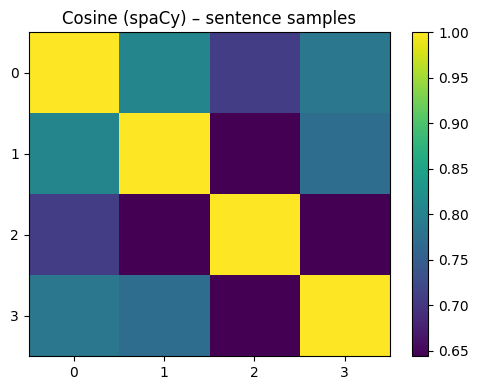

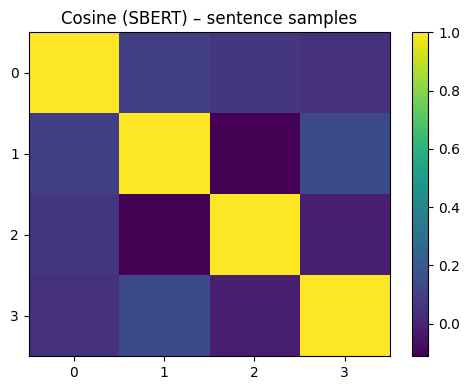

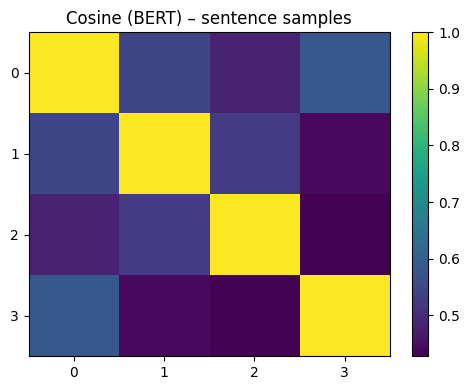

In [13]:

sent_samples = [
    "The king and the queen live in a palace.",
    "Paris is the capital of France.",
    "Apples and bananas are common fruits.",
    "A woman walked to Rome."
]

X_spacy_samp = embed_spacy(sent_samples)
X_sbert_samp = sbert_embed(sent_samples)
X_bert_samp  = bert_sentence_embed(sent_samples)

def show_sent_vectors(name, X, texts, head=8):
    print(f"\n=== {name} sentence vectors ===")
    for s, v in zip(texts, X):
        print(f"\n{s}")
        print(f"first {head} of {len(v)} dims:")
        print(np.array2string(v[:head], precision=4, suppress_small=True))

show_sent_vectors("spaCy", X_spacy_samp, sent_samples)
show_sent_vectors("SBERT", X_sbert_samp, sent_samples)
show_sent_vectors("BERT ", X_bert_samp,  sent_samples)

def cosine_matrix(X):
    return (X @ X.T)  # X is already normalized

def print_cosine_table(name, sims, texts):
    print(f"\n=== Cosine similarities ({name}) ===")
    n = sims.shape[0]
    for i in range(n):
        row = " | ".join(f"{sims[i,j]:.2f}" for j in range(n))
        print(f"{i:02d} {row}  <- {texts[i]}")

S_spacy = cosine_matrix(X_spacy_samp)
S_sbert = cosine_matrix(X_sbert_samp)
S_bert  = cosine_matrix(X_bert_samp)

print_cosine_table("spaCy", S_spacy, sent_samples)
print_cosine_table("SBERT", S_sbert, sent_samples)
print_cosine_table("BERT ", S_bert,  sent_samples)

def plot_heatmap(sim, title, labels):
    plt.figure(figsize=(5,4))
    plt.imshow(sim, aspect='auto')
    plt.title(title)
    plt.xticks(range(len(labels)), range(len(labels)))
    plt.yticks(range(len(labels)), range(len(labels)))
    plt.colorbar()
    plt.tight_layout()
    plt.show()

plot_heatmap(S_spacy, "Cosine (spaCy) – sentence samples", sent_samples)
plot_heatmap(S_sbert, "Cosine (SBERT) – sentence samples", sent_samples)
plot_heatmap(S_bert,  "Cosine (BERT) – sentence samples", sent_samples)


## 8) Cosine Similarities (word-level)

In [14]:

pairs = [
    ("king","queen"),
    ("king","man"),
    ("queen","woman"),
    ("paris","france"),
    ("rome","italy"),
    ("apple","banana"),
    ("king","apple"),
]

def cosine_table(name, vec_fn):
    print(f"\n=== Cosine similarities ({name}) ===")
    for a, b in pairs:
        va, vb = vec_fn(a), vec_fn(b)
        if va is not None and vb is not None:
            print(f"{a:>6} ~ {b:<6}: {cos(va, vb):.3f}")

cosine_table("Word2Vec", lambda w: vec_gensim_word(w2v_kv, w))
cosine_table("FastText", lambda w: vec_gensim_word(ft_kv, w))
cosine_table("GloVe",   vec_glove_word)



=== Cosine similarities (Word2Vec) ===
  king ~ queen : 0.428
  king ~ man   : 0.281
 queen ~ woman : 0.346
 paris ~ france: 0.610
  rome ~ italy : 0.558
 apple ~ banana: 0.297
  king ~ apple : 0.390

=== Cosine similarities (FastText) ===
  king ~ queen : 0.654
  king ~ man   : 0.627
 queen ~ woman : 0.628
 paris ~ france: 0.748
  rome ~ italy : 0.704
 apple ~ banana: 0.823
  king ~ apple : 0.811

=== Cosine similarities (GloVe) ===
  king ~ queen : 0.751
  king ~ man   : 0.512
 queen ~ woman : 0.510
 paris ~ france: 0.748
  rome ~ italy : 0.653
 apple ~ banana: 0.505
  king ~ apple : 0.267


## 9) Analogy: king - man + woman (no temp vectors)

In [15]:

def analogy(model, a, b, c, topn=5):
    if not all(w in model.key_to_index for w in [a,b,c]): return []
    return model.most_similar(positive=[a, c], negative=[b], topn=topn)

print("\n=== Analogy: king - man + woman ≈ ? ===")
print("Word2Vec ->"); pprint(analogy(w2v_kv, "king","man","woman"))
print("FastText ->"); pprint(analogy(ft_kv,  "king","man","woman"))
print("GloVe   ->");  pprint(glove.most_similar(positive=["king","woman"], negative=["man"], topn=5))



=== Analogy: king - man + woman ≈ ? ===
Word2Vec ->
[('markets', 0.3997083306312561),
 ('france', 0.38170817494392395),
 ('found', 0.3718187212944031),
 ('european', 0.3491322696208954),
 ('across', 0.3458816409111023)]
FastText ->
[('france', 0.6496921181678772),
 ('countries', 0.6496196389198303),
 ('found', 0.6361705660820007),
 ('cities', 0.6301723718643188),
 ('palace', 0.6285163760185242)]
GloVe   ->
[('queen', 0.7698540687561035),
 ('monarch', 0.6843381524085999),
 ('throne', 0.6755736470222473),
 ('daughter', 0.6594556570053101),
 ('princess', 0.6520534157752991)]


## 10) Sentence Semantic Search & Clustering

In [16]:

X_sbert_all = sbert_embed(SENTENCES)
X_bert_all  = bert_sentence_embed(SENTENCES)
X_spacy_all = embed_spacy(SENTENCES)

def semantic_search(query, X, encoder, topk=3):
    q = encoder([query])
    S = cosine_similarity(q, X)[0]
    order = np.argsort(S)[::-1][:topk]
    return [(SENTENCES[i], float(S[i])) for i in order]

queries = [
    "capital of a country",
    "royal family and palace",
    "common fruits in markets",
]

print("\n=== Sentence semantic search ===")
for name, X, enc in [
    ("SBERT", X_sbert_all, sbert_embed),
    ("BERT ", X_bert_all,  bert_sentence_embed),
    ("spaCy", X_spacy_all, embed_spacy),
]:
    print(f"\n-- {name} --")
    for q in queries:
        print(q, "->")
        pprint(semantic_search(q, X, enc))

for name, X in [("SBERT", X_sbert_all), ("BERT", X_bert_all), ("spaCy", X_spacy_all)]:
    k = 3
    km = KMeans(n_clusters=k, n_init=10, random_state=42).fit(X)
    sil = silhouette_score(X, km.labels_)
    print(f"{name} clustering silhouette (k={k}): {sil:.3f}")


/usr/local/lib/python3.12/dist-packages/spacy/pipeline/lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)



=== Sentence semantic search ===

-- SBERT --
capital of a country ->
[('Rome is the capital of Italy.', 0.46409860253334045),
 ('Paris is the capital of France.', 0.44035542011260986),
 ('France and Italy are European countries.', 0.3052496910095215)]
royal family and palace ->
[('The royal family rules the kingdom.', 0.7821933627128601),
 ('The king and the queen live in a palace.', 0.7018241882324219),
 ('Paris is the capital of France.', 0.1441422402858734)]
common fruits in markets ->
[('Apples and bananas are common fruits.', 0.7094854712486267),
 ('Bananas are sold in city markets.', 0.6382258534431458),
 ('The royal family rules the kingdom.', 0.13402587175369263)]

-- BERT  --
capital of a country ->
[('Rome is the capital of Italy.', 0.6677862405776978),
 ('Paris is the capital of France.', 0.6400415897369385),
 ('The king and the queen live in a palace.', 0.6388682126998901)]
royal family and palace ->
[('The royal family rules the kingdom.', 0.664501428604126),
 ('The king

/usr/local/lib/python3.12/dist-packages/spacy/pipeline/lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
/usr/local/lib/python3.12/dist-packages/spacy/pipeline/lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
/usr/local/lib/python3.12/dist-packages/spacy/pipeline/lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


## 11) 3D PCA Word Plot with Cosine Edges

Generating 3D plots...


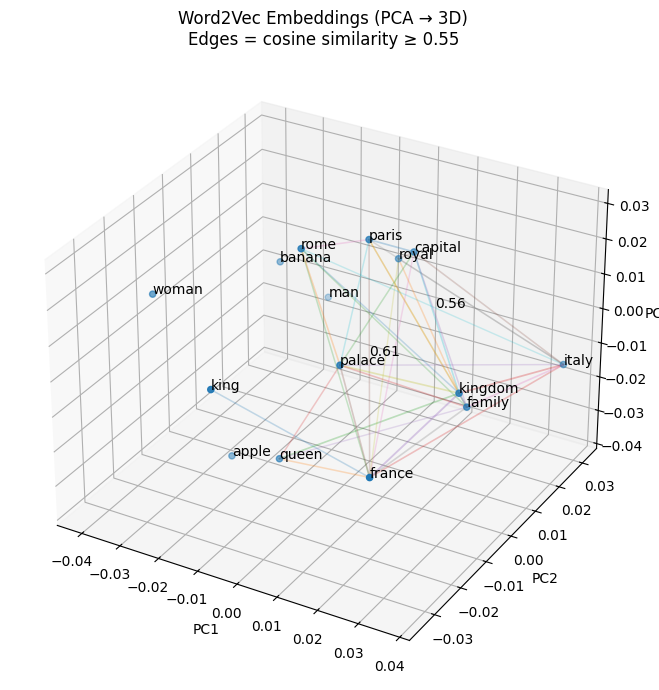

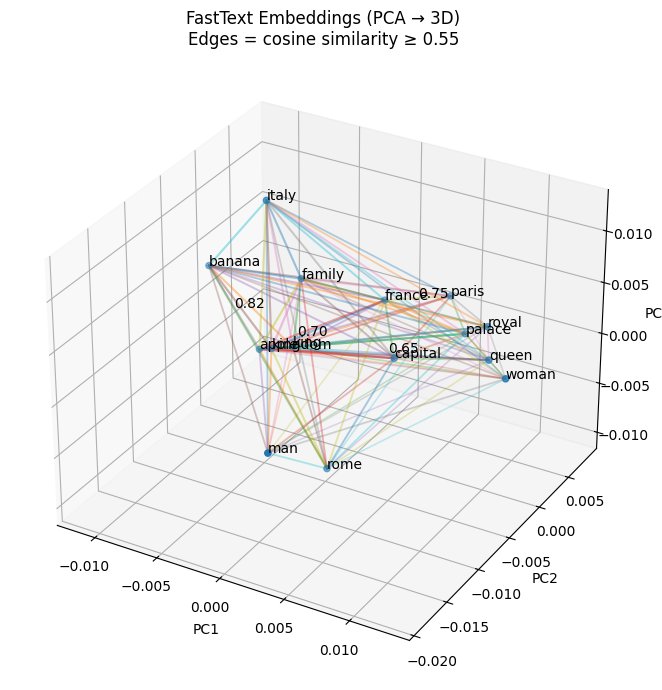

In [17]:

def word_plot_3d_with_edges(model_kv, title, words, edge_threshold=0.55):
    words = [w for w in words if w in model_kv.key_to_index]
    if len(words) < 3:
        print(f"Not enough words for plot: {title}")
        return
    X = np.stack([model_kv[w] for w in words])

    pca = PCA(n_components=3, random_state=0)
    X3 = pca.fit_transform(X)

    Vn = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-9)
    S = (Vn @ Vn.T)  # cosine sim matrix

    fig = plt.figure(figsize=(9,7))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(X3[:,0], X3[:,1], X3[:,2])
    for i, w in enumerate(words):
        ax.text(X3[i,0], X3[i,1], X3[i,2], w)

    for i in range(len(words)):
        for j in range(i+1, len(words)):
            if S[i, j] >= edge_threshold:
                xs = [X3[i,0], X3[j,0]]
                ys = [X3[i,1], X3[j,1]]
                zs = [X3[i,2], X3[j,2]]
                ax.plot(xs, ys, zs, linewidth=1 + 2*(S[i,j]-edge_threshold),
                        alpha=min(0.2 + 0.8*(S[i,j]-edge_threshold), 1.0))

                if (words[i], words[j]) in [("king","queen"), ("paris","france"),
                                            ("rome","italy"), ("apple","banana")] or                    (words[j], words[i]) in [("king","queen"), ("paris","france"),
                                            ("rome","italy"), ("apple","banana")]:
                    mx = (xs[0]+xs[1])/2; my = (ys[0]+ys[1])/2; mz = (zs[0]+zs[1])/2
                    ax.text(mx, my, mz, f"{S[i,j]:.2f}")

    ax.set_title(title + "\nEdges = cosine similarity ≥ " + str(edge_threshold))
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")
    plt.tight_layout()
    plt.show()

print("Generating 3D plots...")
word_plot_3d_with_edges(w2v_kv, "Word2Vec Embeddings (PCA → 3D)", CONTENT_WORDS, edge_threshold=0.55)
word_plot_3d_with_edges(ft_kv,  "FastText Embeddings (PCA → 3D)", CONTENT_WORDS, edge_threshold=0.55)


## 11b) Sentence embeddings: 3D PCA (SBERT vs BERT)

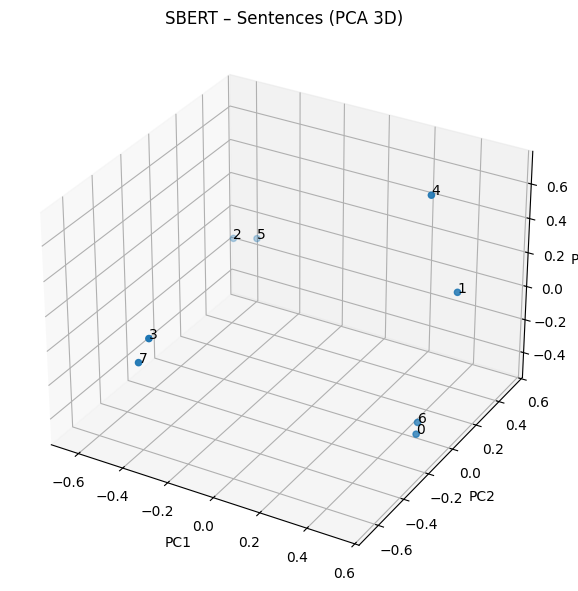

00: Paris is the capital of France.
01: Rome is the capital of Italy.
02: Apples and bananas are common fruits.
03: The king and the queen live in a palace.
04: A woman walked to Rome.
05: Bananas are sold in city markets.
06: France and Italy are European countries.
07: The royal family rules the kingdom.


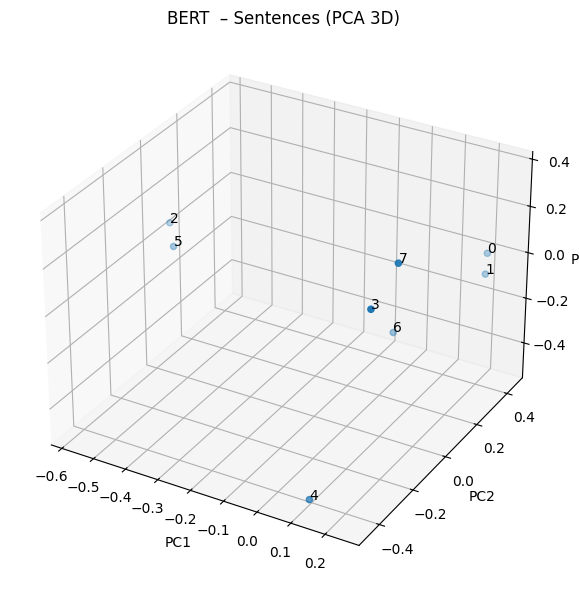

00: Paris is the capital of France.
01: Rome is the capital of Italy.
02: Apples and bananas are common fruits.
03: The king and the queen live in a palace.
04: A woman walked to Rome.
05: Bananas are sold in city markets.
06: France and Italy are European countries.
07: The royal family rules the kingdom.


In [18]:

def plot_sentences_3d(X, title, labels):
    p3 = PCA(n_components=3, random_state=0).fit_transform(X)
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(p3[:,0], p3[:,1], p3[:,2])
    for i, txt in enumerate(labels):
        ax.text(p3[i,0], p3[i,1], p3[i,2], str(i))
    ax.set_title(title)
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")
    plt.tight_layout(); plt.show()
    for i, s in enumerate(labels):
        print(f"{i:02d}: {s}")

plot_sentences_3d(X_sbert_all, "SBERT – Sentences (PCA 3D)", SENTENCES)
plot_sentences_3d(X_bert_all,  "BERT  – Sentences (PCA 3D)", SENTENCES)


## 12) (Optional) UMAP 2D Visualizations (words & sentences)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/numba/np/ufunc/parallel.py:373: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


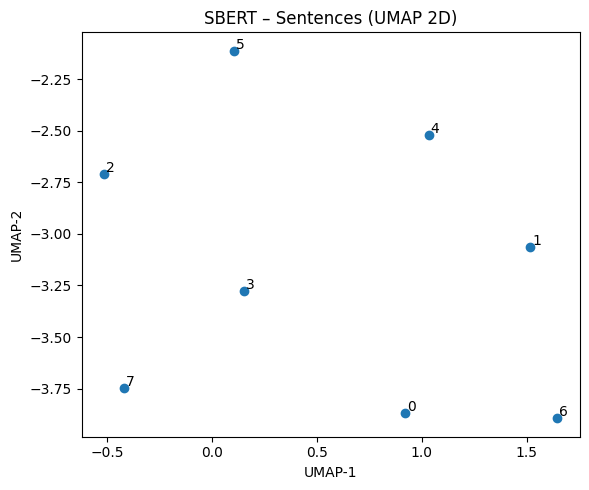

00: Paris is the capital of France.
01: Rome is the capital of Italy.
02: Apples and bananas are common fruits.
03: The king and the queen live in a palace.
04: A woman walked to Rome.
05: Bananas are sold in city markets.
06: France and Italy are European countries.
07: The royal family rules the kingdom.


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


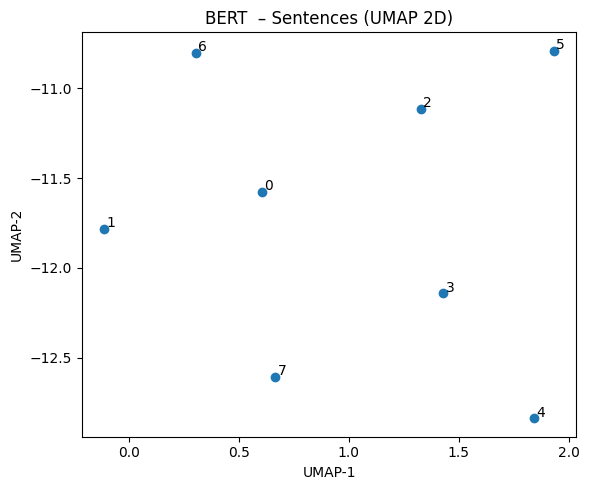

00: Paris is the capital of France.
01: Rome is the capital of Italy.
02: Apples and bananas are common fruits.
03: The king and the queen live in a palace.
04: A woman walked to Rome.
05: Bananas are sold in city markets.
06: France and Italy are European countries.
07: The royal family rules the kingdom.


In [19]:

def word_umap_plot(model_kv, title, words):
    words = [w for w in words if w in model_kv.key_to_index]
    if len(words) < 3:
        print(f"Not enough words for plot: {title}")
        return
    X = np.stack([model_kv[w] for w in words])
    X2 = umap.UMAP(n_components=2, random_state=0, n_neighbors=10, min_dist=0.1).fit_transform(X)
    plt.figure(figsize=(6,5))
    plt.scatter(X2[:,0], X2[:,1])
    for i,w in enumerate(words):
        plt.text(X2[i,0]+0.01, X2[i,1]+0.01, w)
    plt.title(title); plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
    plt.tight_layout(); plt.show()

def plot_sentences_umap(X, title, labels):
    u = umap.UMAP(n_components=2, random_state=0, n_neighbors=8, min_dist=0.1).fit_transform(X)
    plt.figure(figsize=(6,5))
    plt.scatter(u[:,0], u[:,1])
    for i, txt in enumerate(labels):
        plt.text(u[i,0]+0.01, u[i,1]+0.01, str(i))
    plt.title(title); plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
    plt.tight_layout(); plt.show()
    for i, s in enumerate(labels):
        print(f"{i:02d}: {s}")

# Word 2D plots (uncomment to run)
# word_umap_plot(w2v_kv, "Word2Vec (UMAP 2D)", CONTENT_WORDS)
# word_umap_plot(ft_kv,  "FastText (UMAP 2D)", CONTENT_WORDS)

# Sentence 2D plots (SBERT vs BERT)
plot_sentences_umap(X_sbert_all, "SBERT – Sentences (UMAP 2D)", SENTENCES)
plot_sentences_umap(X_bert_all,  "BERT  – Sentences (UMAP 2D)", SENTENCES)


## 13) Word analogy arrows in 3D (PCA) and 2D (UMAP)

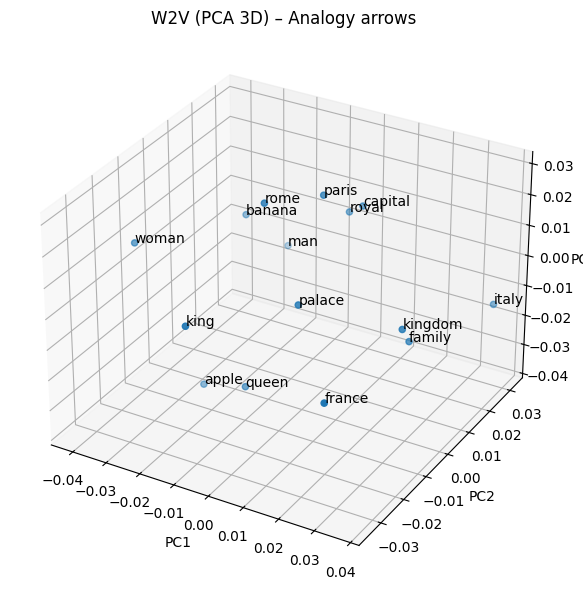

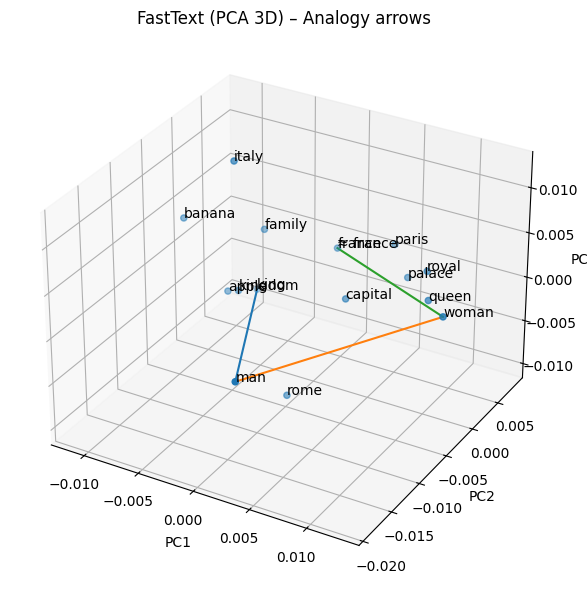

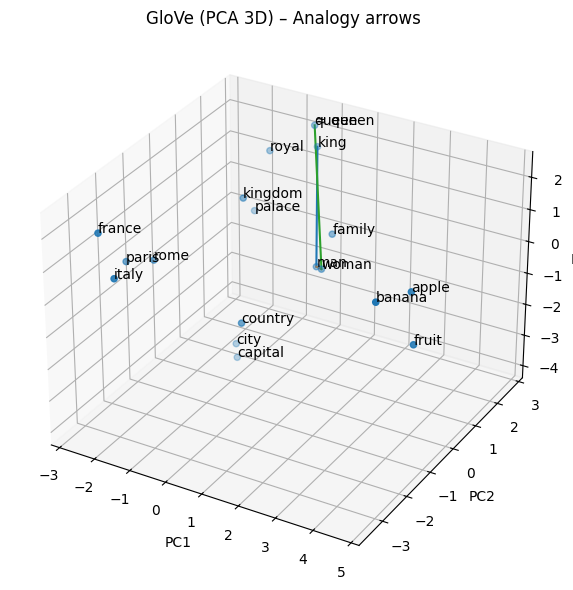

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


ValueError: 'markets' is not in list

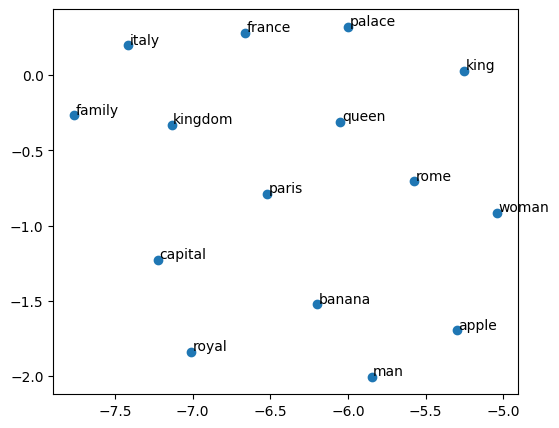

In [20]:

def analogy_target(model_kv, a, b, c):
    if not all(w in model_kv.key_to_index for w in [a,b,c]):
        return None, []
    pred = model_kv[a] - model_kv[b] + model_kv[c]
    V = model_kv.vectors
    Vn = V / (np.linalg.norm(V, axis=1, keepdims=True) + 1e-9)
    p = pred / (np.linalg.norm(pred) + 1e-9)
    sims = Vn @ p
    idx2w = [None]*len(model_kv.key_to_index)
    for w, i in model_kv.key_to_index.items():
        idx2w[i] = w
    order = np.argsort(sims)[::-1]
    best = []
    for i in order:
        w = idx2w[i]
        if w in {a,b,c}:
            continue
        best.append((w, float(sims[i])))
        if len(best) == 5:
            break
    return pred, best

def word_analogy_plot_3d(model_kv, title, words, triplet=("king","man","woman")):
    words = [w for w in words if w in model_kv.key_to_index]
    if not words:
        print("No words to plot");
        return
    X = np.stack([model_kv[w] for w in words])
    p3 = PCA(n_components=3, random_state=0).fit_transform(X)
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(p3[:,0], p3[:,1], p3[:,2])
    for i, w in enumerate(words):
        ax.text(p3[i,0], p3[i,1], p3[i,2], w)
    a,b,c = triplet
    if all(w in model_kv.key_to_index for w in [a,b,c]):
        pred_vec, best = analogy_target(model_kv, a,b,c)
        if best:
            target = best[0][0]
            def proj(w): return p3[words.index(w)]
            try:
                A,B,C,T = proj(a), proj(b), proj(c), proj(target)
                ax.plot([A[0],B[0]],[A[1],B[1]],[A[2],B[2]])
                ax.plot([B[0],C[0]],[B[1],C[1]],[B[2],C[2]])
                ax.plot([C[0],T[0]],[C[1],T[1]],[C[2],T[2]])
                ax.text(T[0], T[1], T[2], f"≈ {target}")
            except ValueError:
                pass
    ax.set_title(title + " – Analogy arrows")
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")
    plt.tight_layout(); plt.show()

def word_analogy_plot_2d(model_kv, title, words, triplet=("king","man","woman")):
    words = [w for w in words if w in model_kv.key_to_index]
    if len(words) < 3:
        print("Not enough words"); return
    X = np.stack([model_kv[w] for w in words])
    u = umap.UMAP(n_components=2, random_state=0, n_neighbors=8, min_dist=0.1).fit_transform(X)
    plt.figure(figsize=(6,5))
    plt.scatter(u[:,0], u[:,1])
    for i, w in enumerate(words):
        plt.text(u[i,0]+0.01, u[i,1]+0.01, w)
    a,b,c = triplet
    if all(w in model_kv.key_to_index for w in [a,b,c]) and all(w in words for w in [a,b,c]):
        pred_vec, best = analogy_target(model_kv, a,b,c)
        if best:
            target = best[0][0]
            A = u[words.index(a)]; B = u[words.index(b)]
            Cp = u[words.index(c)]; T = u[words.index(target)]
            plt.plot([A[0],B[0]],[A[1],B[1]])
            plt.plot([B[0],Cp[0]],[B[1],Cp[1]])
            plt.plot([Cp[0],T[0]],[Cp[1],T[1]])
            plt.text(T[0], T[1], f"≈ {target}")
    plt.title(title + " – Analogy arrows")
    plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
    plt.tight_layout(); plt.show()

# Draw for W2V/FT; GloVe via wrapper
word_analogy_plot_3d(w2v_kv, "W2V (PCA 3D)", CONTENT_WORDS, ("king","man","woman"))
word_analogy_plot_3d(ft_kv,  "FastText (PCA 3D)", CONTENT_WORDS, ("king","man","woman"))

class SimpleKV:
    def __init__(self, words):
        self.key_to_index = {w:i for i,w in enumerate(words)}
        self.vecs = np.stack([glove[w] for w in words])
    def __getitem__(self, w): return self.vecs[self.key_to_index[w]]
    @property
    def vectors(self): return self.vecs

glove_words = [w for w in CONTENT_WORDS if w in glove.key_to_index]
if len(glove_words) >= 4:
    gkv = SimpleKV(glove_words)
    word_analogy_plot_3d(gkv, "GloVe (PCA 3D)", glove_words, ("king","man","woman"))
    word_analogy_plot_2d(w2v_kv, "W2V (UMAP 2D)", CONTENT_WORDS, ("king","man","woman"))
    word_analogy_plot_2d(ft_kv,  "FastText (UMAP 2D)", CONTENT_WORDS, ("king","man","woman"))
    word_analogy_plot_2d(gkv,    "GloVe (UMAP 2D)", glove_words, ("king","man","woman"))
